# Zoo Animal Classifier

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from scipy import stats
import time
from sklearn.model_selection import KFold
import torch.utils.data.sampler
import os
from PIL import Image
import math


# Data

In [114]:
# Define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Get class names and mappings
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define animal classes
animal_classes = [1, 3, 4, 15, 21, 27, 30, 31, 34, 38, 42, 43, 44, 50, 72, 73, 78, 88, 93, 97]

# Create label mappings
label_to_new_label = {label: idx for idx, label in enumerate(animal_classes)}
new_label_to_class_name = {idx: idx_to_class[label] for label, idx in label_to_new_label.items()}

# Get indices of animal class samples
train_labels = train_dataset.targets
test_labels = test_dataset.targets

animal_train_indices = [i for i, label in enumerate(train_labels) if label in animal_classes]
animal_test_indices = [i for i, label in enumerate(test_labels) if label in animal_classes]

Files already downloaded and verified
Files already downloaded and verified


In [115]:
# Create custom dataset for animals
class AnimalCIFAR100Dataset(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        new_label = self.label_map[label]
        return img, new_label

# Create animal datasets
train_dataset_animals = AnimalCIFAR100Dataset(Subset(train_dataset, animal_train_indices), label_to_new_label)
test_dataset_animals = AnimalCIFAR100Dataset(Subset(test_dataset, animal_test_indices), label_to_new_label)

# Create data loaders
train_loader = DataLoader(train_dataset_animals, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_animals, batch_size=64, shuffle=False)

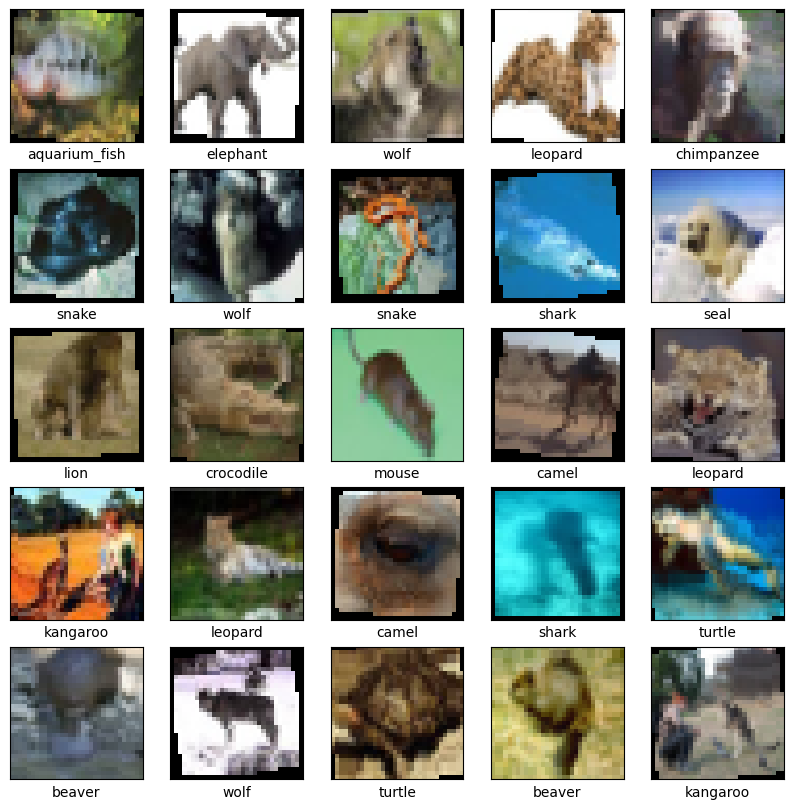

In [116]:
# Visualize some images
images, labels = zip(*[train_dataset_animals[i] for i in range(25)])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.xlabel(new_label_to_class_name[labels[i]])
plt.show()

# Pre-trained Transfer Learning Model (ResNet)

In [117]:
# Device configuration
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
    print("Using MPS backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using MPS backend


In [118]:
# Model setup
model = models.resnet152(pretrained=True)

# Modify for CIFAR-100 images (32x32)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/opt/anaconda3/envs/325-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Loop

In [119]:
# Training loop
num_epochs = 10
best_val_loss = float('inf')

train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to device with correct dtype
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    epoch_acc = correct.float() / len(train_loader.dataset)
    train_accuracy.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    time.sleep(30)


Epoch 1/10, Loss: 1.9548, Acc: 0.4034
Epoch 2/10, Loss: 1.1738, Acc: 0.6370
Epoch 3/10, Loss: 0.8265, Acc: 0.7452
Epoch 4/10, Loss: 0.6578, Acc: 0.7925
Epoch 5/10, Loss: 0.5096, Acc: 0.8402
Epoch 6/10, Loss: 0.3784, Acc: 0.8810
Epoch 7/10, Loss: 0.3344, Acc: 0.8934
Epoch 8/10, Loss: 0.1925, Acc: 0.9423
Epoch 9/10, Loss: 0.1299, Acc: 0.9625
Epoch 10/10, Loss: 0.1045, Acc: 0.9716


### Plot Training 

<Figure size 1300x600 with 0 Axes>

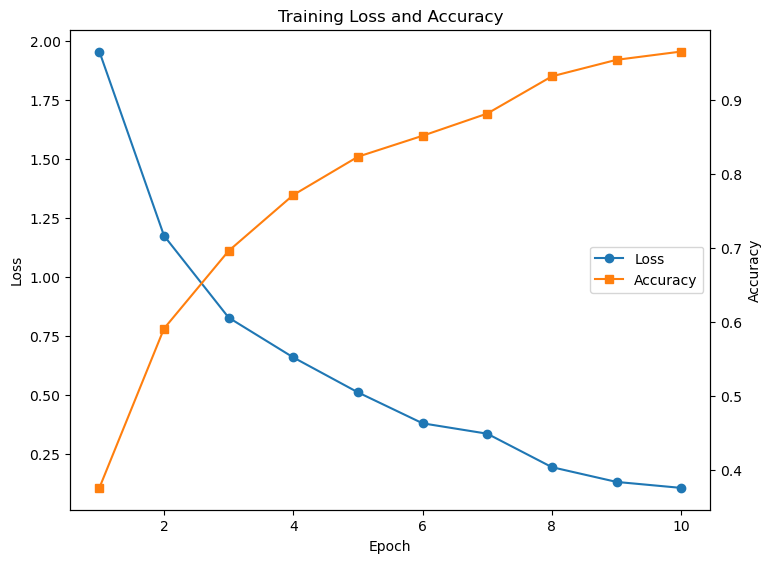

In [120]:
# Plot the training loss and accuracy
plt.figure(figsize=(13, 6))

fig, ax1 = plt.subplots()

# Plot the training loss on the left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
l1 = ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Loss', color='tab:blue', marker='o')

# Plot the training accuracy on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
l2 = ax2.plot(range(1, len(train_accuracy_device) + 1), train_accuracy_device, label='Accuracy', color='tab:orange', marker='s')

l = l1 + l2
ls = [l.get_label() for l in l]
ax2.legend(l, ls, loc=5)

plt.title('Training Loss and Accuracy')
#fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=1)

plt.show()


### Uncomment to Save Model

In [121]:
# model_path = 'model.pth'

# # Save the state dictionary

# torch.save(model.state_dict(), model_path)

# print(f'Model saved to {model_path}')

#### Uncomment to load saved model

In [122]:
# # Re-instantiate the model architecture
# model = models.resnet152(pretrained=False)

# # Modify for CIFAR-100 images (32x32)
# model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.maxpool = torch.nn.Identity()

# # Replace the final layer
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# # Load the saved state dictionary
# model.load_state_dict(torch.load('animal_classifier_resnet152.pth'))

# # Move the model to the desired device
# model = model.to(device)

# print("Model loaded successfully.")

# Model Evaluation

In [123]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8120


### 95% Confidence Interval

In [124]:
confidence_level = 0.95
Z = stats.norm.ppf((1+confidence_level)/2)
CI = Z * np.sqrt(test_accuracy*(1-test_accuracy)/total)
lb = test_accuracy - CI
ub = test_accuracy + CI

print(f'95% Confidence Interval for model accuracy: {lb*100:.2f} - {ub*100:.2f}')

95% Confidence Interval for model accuracy: 79.49 - 82.91


### K-Fold Cross Validation

In [125]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device) 
loss_function = nn.CrossEntropyLoss()
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
results = {}

# train
for fold, (train_ids, test_ids) in enumerate(kf.split(train_dataset_animals)):
    print(f'Fold {fold + 1}/{num_splits}')

    train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.sampler.SubsetRandomSampler(test_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset_animals, batch_size=10, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(train_dataset_animals, batch_size=10, sampler=test_subsampler)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(0, 10):
        print(f'epoch {epoch}')
        current_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)  # Move both inputs and targets to the same device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % 500 == 499:
                #print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
                current_loss = 0.0
        time.sleep(5)

    # evaluate
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (pred == targets).sum().item()    
            #print(f'accuracy for fold {fold}: {100.0 * correct/total}')
            results[fold] = 100.0 * (correct / total)
    
    time.sleep(5)
        
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

Fold 1/5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Fold 2/5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Fold 3/5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Fold 4/5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Fold 5/5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Fold 0: 70.45 %
Fold 1: 81.89999999999999 %
Fold 2: 87.55 %
Fold 3: 89.60000000000001 %
Fold 4: 93.4 %
Average: 84.58 %


# Testing Custom Images

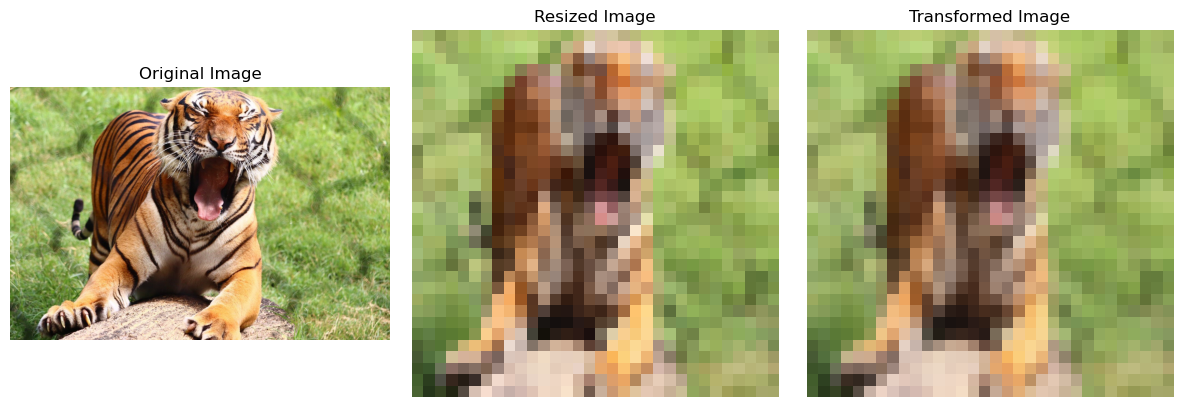

In [142]:
image_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transformed_image = image_transform(image).unsqueeze(0)  # Flatten for model input
    return transformed_image

def visualize_image_transform(image_path):
    image = Image.open(image_path)

    # Original Image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # After resizing
    image_resized = image.resize((32, 32))
    plt.subplot(1, 3, 2)
    plt.imshow(image_resized, cmap='gray')
    plt.title('Resized Image')
    plt.axis('off')

    # After transformation
    transformed_image = image_transform(image).squeeze().numpy()  # Squeeze to remove channel dimension for display
    transformed_image = transformed_image.transpose(1,2,0)
    plt.subplot(1, 3, 3)
    plt.imshow(transformed_image)
    plt.title('Transformed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_image_transform('images/tiger.jpg')

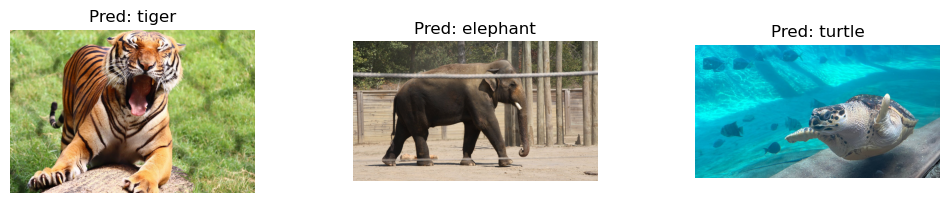

In [140]:

model = model.to(device)
def test_model_on_custom_images(model, folder_path, device):
    # Get image files
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]
    num_images = len(image_files)

    # Calculate grid size (rows and columns)
    cols = 3  # Number of columns
    rows = math.ceil(num_images / cols)  # Dynamically calculate rows
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size dynamically
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Iterate over image files
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        input_image = load_and_preprocess_image(image_path).to(device)

        # Model inference
        with torch.no_grad():
            output = model(input_image)
            predicted_label = torch.argmax(output, dim=1).item()  # Get the predicted class label

        # Display image and prediction
        ax = axes[i]
        ax.imshow(Image.open(image_path))
        #ax.set_title(f'Pred: {predicted_label}')
        ax.set_title(f'Pred: {new_label_to_class_name[predicted_label]}')
        ax.axis('off')

    # Turn off unused axes
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')

    plt.show()


test_model_on_custom_images(model, './images', device)


In [141]:
from torchsummary import summary
summary(model.to("cpu"), input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
          Identity-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]           4,096
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
             ReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11        [-1, 256, 224, 224]          16,384
      BatchNorm2d-12        [-1, 256, 224, 224]             512
           Conv2d-13        [-1, 256, 224, 224]          16,384
      BatchNorm2d-14        [-1, 256, 2

## Team Member Contributions:

**Braden Hechmer**

Braden implemented the initial pytorch model and training loop this notebook is based on.

**Daniel Mallett**

Daniel worked to futher improve and explain the resulting model. He experimented with different size models, ultimately selecting resnet152. He implemented K-Fold cross-validation and added the ability to test the model on custom inputs.

**Maxwell Marcum**

Maxwell collaborated with Daniel on K-Fold cross validation and worked to design and print the poster.